# SENE Ratio Chart Creator

This notebook is designed to process and visualize data related to SENE ratios. It provides a comprehensive workflow for data cleaning, analysis, and advanced Excel formatting. The operations are structured to ensure clarity and reproducibility.

## Operations Flow

1. **Import Required Libraries**: Load necessary Python libraries for data manipulation, visualization, and Excel formatting.
2. **Define Constants**: Set up constants such as file names and configuration flags.
3. **Data Cleaning**: Implement a function to clean and preprocess data from the input CSV file.
4. **Read and Process CSV Data**: Read the input CSV file, clean the data, and structure it for further analysis.
5. **Export Data to Excel**: Save the processed data into an Excel file for easy sharing and reporting.
6. **Advanced Excel Formatting**: Apply advanced formatting to the Excel file, including conditional formatting, custom headers, and dynamic column widths.
7. **Reorder Components**: Reorganize the components in the processed data to match a predefined structure and save the reordered data to a new Excel file.

## Key Features

- **Data Cleaning**: Handles missing values, trims whitespace, and converts data types.
- **Visualization**: Prepares data for visualization using libraries like Matplotlib.
- **Excel Formatting**: Enhances Excel files with features like conditional formatting and custom styles.
- **Reordering Components**: Ensures data consistency by reordering components in a structured format.

## How to Use

1. Place the input CSV file (`run_name_SED.csv`) in the same directory as this notebook.
2. Run each cell sequentially to process the data and generate the output files.
3. The processed data will be saved as `processed_data_SED.xlsx` and `reordered_processed_data_SED.xlsx`.

---

**Author**: Adam Kołakowski
**Date**: 28 kwietnia 2025
**Environment**: macOS

# Import Required Libraries
<p>In this section, we import the necessary libraries for data processing and visualization. These include:</p>
<ul>
<li><code>csv</code>: For reading and writing CSV files.</li>
<li><code>pandas</code>: For data manipulation and saving to Excel.</li>
<li><code>openpyxl</code>: For advanced Excel formatting.</li>
<li><code>matplotlib</code>: For creating plots.</li>
</ul>

In [2]:
import csv  # Import the built-in CSV module for reading CSV files
import pandas as pd  # Import pandas for data manipulation and saving to Excel
import matplotlib.pyplot as plt  # Import matplotlib for creating plots
import matplotlib.ticker as mtick # Import ticker for formatting axis ticks
import matplotlib.colors as mcolors  # Import matplotlib for color handling
from openpyxl import load_workbook  # Import openpyxl for advanced Excel formatting
from openpyxl.cell.cell import Cell  # Import Cell class for working with individual cells
from openpyxl.utils import get_column_letter  # Import utility to convert column index to letter
from openpyxl.styles import Border, Side, PatternFill, Font, Alignment  # Import styles for Excel formatting
from openpyxl.formatting.rule import ColorScaleRule  # Import rule for conditional formatting in Excel

# Define Constants
<p>Here, we define constants that control the behavior of the script:</p>
<ul>
<li><code>INCLUDE_SED</code>: A flag to include or exclude SED columns in the output.</li>
<li><code>file_name</code>: The name of the input CSV file.</li>
<li><code>output_file</code>: The name of the primary output Excel file.</li>
<li><code>output_file_reordered</code>: The name of the reordered output Excel file.</li>
</ul>

In [3]:
# Flag to control output format
INCLUDE_SED = 0  # Set to 1 to include SED columns, 0 to exclude them

# Define the CSV file name and output file name
file_name = "run_name_SED.csv"
output_file = "processed_data_SED.xlsx"
output_file_reordered = "processed_data_SED_Reordered.xlsx"

# Data Cleaning Function
<p>This function, <code>clean_value</code>, is responsible for cleaning and converting values from the CSV file. It performs the following tasks:</p>
<ul>
<li>Strips whitespace from values.</li>
<li>Converts numerical values to <code>int</code> or <code>float</code>.</li>
<li>Replaces empty or missing values with <code>0</code>.</li>
</ul>

In [4]:
# Read the CSV file
def clean_value(value):
    if value is None or value.strip() == "": # Handle missing or empty values
        return 0
    value = value.strip() # Remove leading and trailing spaces
    
    try:
        num = float(value) # Attempt to convert to float
        if num.is_integer(): # If the number is an integer (e.g., 3.0 -> 3)
            return int(num)
        return num # Return as float if it has decimal places
    except ValueError:
        return value # If conversion fails, return the original string

# List to store processed data
processed_data = []
modes = []
airfoil_ratios = []


# Reading and Processing CSV Data
<p>In this section, we:</p>
<ul>
<li>Open the CSV file using <code>csv.DictReader</code>.</li>
<li>Clean column names by stripping spaces.</li>
<li>Iterate through each row, clean values, and extract relevant data.</li>
<li>Sort component ratios and store them in a structured format.</li>
</ul>

In [5]:
# Open the CSV file for reading	
with open(file_name, newline='') as csv_file:
    csv_reader = csv.DictReader(csv_file, delimiter=',') # Read CSV as dictionary

	# Strip spaces from column names to ensure consistency
    if csv_reader.fieldnames:
        csv_reader.fieldnames = [col.strip() for col in csv_reader.fieldnames]

    # Print column names if available, otherwise print an error message
    if csv_reader.fieldnames:
        print(f'Column names: {",".join(csv_reader.fieldnames)}')
    else:
        print('No column names found.')

# Process each row in the CSV file
    line_count = 0
    for row in csv_reader:
    # Clean each value in the row and store it in a new dictionary
        row = {key.strip(): clean_value(value) for key, value in row.items()}

    # Basic info
        base = {
            "Mode#": row["mode"],
            "Frequency [Hz]": row["FREQ"]
        }

        # Extract component ratios and sort
        components = {
            "Airfoil": row["SENE_AERO_ratio"],
            "Inner Band": row["SENE_IB_Ratio"],
            "Honey Comb": row["SENE_HC_Ratio"],
            "Outer Band": row["SENE_OB_Ratio"]
        }
        sorted_components = sorted(components.items(), key=lambda x: x[1], reverse=True)

        for i, (name, value) in enumerate(sorted_components, start=1):
            base[f"Component {i}"] = name
            base[f"%  {i}"] = value

        processed_data.append(base)
        line_count += 1

Column names: mode,FREQ,SENE_AERO_ratio,SENE_IB_Ratio,SENE_HC_Ratio,SENE_OB_Ratio,MAX_SED_LYNN,MAX_SED_ALT


# Exporting Data to Excel
<p>Here, we:</p>
<ul>
<li>Convert the processed data into a <code>pandas.DataFrame</code>.</li>
<li>Save the DataFrame to an Excel file using <code>to_excel</code>.</li>
<li>Print the total number of processed lines and the output file name.</li>
</ul>

In [6]:
# Convert to DataFrame and save to Excel
df = pd.DataFrame(processed_data)

# Print total processed lines
print(f'Processed {line_count} lines. Output saved to {output_file}')

# Create and export the sorted DataFrame
df_sorted = pd.DataFrame(processed_data)

df_sorted.to_excel(output_file, index=False)  # Save to Excel

Processed 43 lines. Output saved to processed_data_SED.xlsx


# Advanced Excel Formatting
<p>The <code>apply_advanced_formatting</code> function enhances the Excel file by:</p>
<ul>
<li>Adding new rows and columns for better structure.</li>
<li>Setting default fonts and custom headers.</li>
<li>Adjusting column widths dynamically based on content.</li>
<li>Applying borders and alignment settings to cells.</li>
<li>Highlighting specific components (e.g., 'Airfoil') with custom styles.</li>
<li>Adding conditional formatting for percentage columns.</li>
</ul>

In [7]:
def apply_advanced_formatting(file_path):
    # Load the workbook and get the first worksheet
    wb = load_workbook(file_path)
    ws = wb[wb.sheetnames[0]]

    # Insert a new column at the beginning and a new row at the top
    ws.insert_cols(1)
    ws.insert_rows(1)

    # Set default font for all cells
    default_font = Font(size=18)
    for row in ws.iter_rows(min_row=2, max_row=ws.max_row):
        for cell in row:
            cell.font = default_font

    # Set custom headers
    new_headers = ["Mode", "Freq [Hz]"]
    for i in range(1, 5):
        new_headers.append(f"Comp {i}")
        new_headers.append(f"Comp {i} [%]")

    for col_idx, header in enumerate(new_headers, start=2):
        cell = ws.cell(row=2, column=col_idx)
        cell.value = header

    # Set column widths based on header and data
    for col_idx in range(2, ws.max_column + 1):
        max_length = 0
        col_letter = get_column_letter(col_idx)

        # Check header in row 2
        header_cell = ws.cell(row=2, column=col_idx)
        if header_cell.value:
            max_length = len(str(header_cell.value))

        # Check all data rows
        for row_idx in range(3, ws.max_row + 1):
            cell = ws.cell(row=row_idx, column=col_idx)
            if cell.value:
                max_length = max(max_length, len(str(cell.value)))

        # Adjust column width with padding
        adjusted_width = max(12, max_length * 1.5 + 4)
        ws.column_dimensions[col_letter].width = adjusted_width

        # Apply alignment settings to the whole column
        for row_idx in range(2, ws.max_row + 1):
            cell = ws.cell(row=row_idx, column=col_idx)
            cell.alignment = Alignment(
                wrap_text=False,
                shrink_to_fit=False,
                horizontal='center'
            )

    # Apply thin border to all cells
    thin_border = Border(
        left=Side(style='thin'),
        right=Side(style='thin'),
        top=Side(style='thin'),
        bottom=Side(style='thin')
    )

    for row in ws.iter_rows(min_row=2, max_row=ws.max_row, min_col=2, max_col=ws.max_column):
        for cell in row:
            cell.border = thin_border

    # Apply double border around the table
    double_side = Side(style='double', color='19386B')

    min_row, max_row = 2, ws.max_row
    min_col, max_col = 2, ws.max_column

    for row in range(min_row, max_row + 1):
        for col in range(min_col, max_col + 1):
            cell = ws.cell(row=row, column=col)

            # Create a border for the cell
            border = Border(
                left=double_side if col == min_col else None,
                right=double_side if col == max_col else None,
                top=double_side if row == min_row else None,
                bottom=double_side if row == max_row else None
            )

            # Apply the border to the cell
            cell.border = Border(
                left=border.left if border.left else cell.border.left,
                right=border.right if border.right else cell.border.right,
                top=border.top if border.top else cell.border.top,
                bottom=border.bottom if border.bottom else cell.border.bottom,
            )

    # Apply ColorScaleRule formatting to percentage columns
    percent_columns = ['E', 'G', 'I', 'K']
    color_scale_rule = ColorScaleRule(
        start_type='num', start_value=0.0, start_color='D9EAD3',
        mid_type='num', mid_value=0.5, mid_color='FCE5CD',
        end_type='num', end_value=1.0, end_color='E69138'
    )

    for col_letter in percent_columns:
        ws.conditional_formatting.add(f"{col_letter}3:{col_letter}{ws.max_row}", color_scale_rule)

    # Format percentage cells to show 'XX%' style
    for col_letter in percent_columns:
        for row in range(3, ws.max_row + 1):
            cell = ws[f"{col_letter}{row}"]
            if isinstance(cell.value, (int, float)):
                cell.number_format = '0%'

    # Highlight 'Airfoil' with red font and yellow fill
    highlight_font = Font(color='C00000', bold=True, size=18)
    highlight_fill = PatternFill(fill_type='solid', fgColor='FFFE5D')

    component_to_percent = ['D', 'F', 'H', 'J']

    for comp_col in component_to_percent:
        for row in range(3, ws.max_row + 1):
            comp_cell = ws[f"{comp_col}{row}"]
            if comp_cell.value == "Airfoil":
                comp_cell.font = highlight_font
                comp_cell.fill = highlight_fill

 # Save the workbook
    wb.save(file_path)
    print(f"Formatting applied to {file_path}")

# Apply advanced formatting to the primary file
apply_advanced_formatting(output_file)

Formatting applied to processed_data_SED.xlsx


# Reordering Components
<p>In this section, we reorder the components in the processed data to match a predefined structure. The steps include:</p>
<ul>
<li>Loading data from the Excel file.</li>
<li>Reordering components into a consistent format.</li>
<li>Saving the reordered data to a new Excel file.</li>
</ul>

In [10]:
def reorder_components(input_file, output_file):
    global reordered_df  # Declare the global variable to be used in the function
    # Load data from the Excel file
    df = pd.read_excel(input_file, skiprows=1, usecols=lambda x: 'Unnamed' not in x)

    # Define the new order of components
    components_order = [
        ("Comp 1", "Comp 1 [%]"),
        ("Comp 2", "Comp 2 [%]"),
        ("Comp 3", "Comp 3 [%]"),
        ("Comp 4", "Comp 4 [%]")
    ]

    # New result columns
    reordered_data = {
        "Mode": df["Mode"],
        "Freq [Hz]": df["Freq [Hz]"],
        "Airfoil": [],
        "Airfoil [%]": [],
        "Outer Band": [],
        "Outer Band [%]": [],
        "Inner Band": [],
        "Inner Band [%]": [],
        "Honey Comb": [],
        "Honey Comb [%]": []
    }

    # Iterate through each row and transform data
    for _, row in df.iterrows():
        component_mapping = {}
        for comp_col, percent_col in components_order:
            component_name = row[comp_col]
            component_value = row[percent_col]
            component_mapping[component_name] = component_value

        reordered_data["Airfoil"].append("Airfoil")
        reordered_data["Airfoil [%]"].append(component_mapping.get("Airfoil", 0))
        reordered_data["Outer Band"].append("Outer Band")
        reordered_data["Outer Band [%]"].append(component_mapping.get("Outer Band", 0))
        reordered_data["Inner Band"].append("Inner Band")
        reordered_data["Inner Band [%]"].append(component_mapping.get("Inner Band", 0))
        reordered_data["Honey Comb"].append("Honey Comb")
        reordered_data["Honey Comb [%]"].append(component_mapping.get("Honey Comb", 0))

    # Create a new DataFrame
    reordered_df = pd.DataFrame(reordered_data)

    # Ensure data is displayed in a single row without wrapping
    pd.set_option('display.max_columns', None)  # Show all columns
    pd.set_option('display.expand_frame_repr', False)  # Prevent wrapping to new lines
    print(reordered_df.head())

    # Save data to a new Excel file
    reordered_df.to_excel(output_file, index=False)
    print(f"Data has been transformed and saved to the file {output_file}.")

# Execute the reorder_components function
input_file = "processed_data_SED.xlsx"
output_file = "reordered_processed_data_SED.xlsx"
reorder_components(input_file, output_file)

# Zastosuj to samo zaawansowane formatowanie do pliku z przereorganizowanymi komponentami
apply_advanced_formatting(output_file)  # output_file wskazuje na reordered_processed_data_SED.xlsx

   Mode  Freq [Hz]  Airfoil  Airfoil [%]  Outer Band  Outer Band [%]  Inner Band  Inner Band [%]  Honey Comb  Honey Comb [%]
0     1       1178  Airfoil         0.28  Outer Band            0.06  Inner Band            0.06  Honey Comb            0.00
1     2       2768  Airfoil         0.18  Outer Band            0.08  Inner Band            0.36  Honey Comb            0.02
2     3       7729  Airfoil         0.26  Outer Band            0.06  Inner Band            0.34  Honey Comb            0.04
3     4       8385  Airfoil         0.06  Outer Band            0.03  Inner Band            0.76  Honey Comb            0.04
4     5      10917  Airfoil         0.39  Outer Band            0.07  Inner Band            0.30  Honey Comb            0.03
Data has been transformed and saved to the file reordered_processed_data_SED.xlsx.
Formatting applied to reordered_processed_data_SED.xlsx


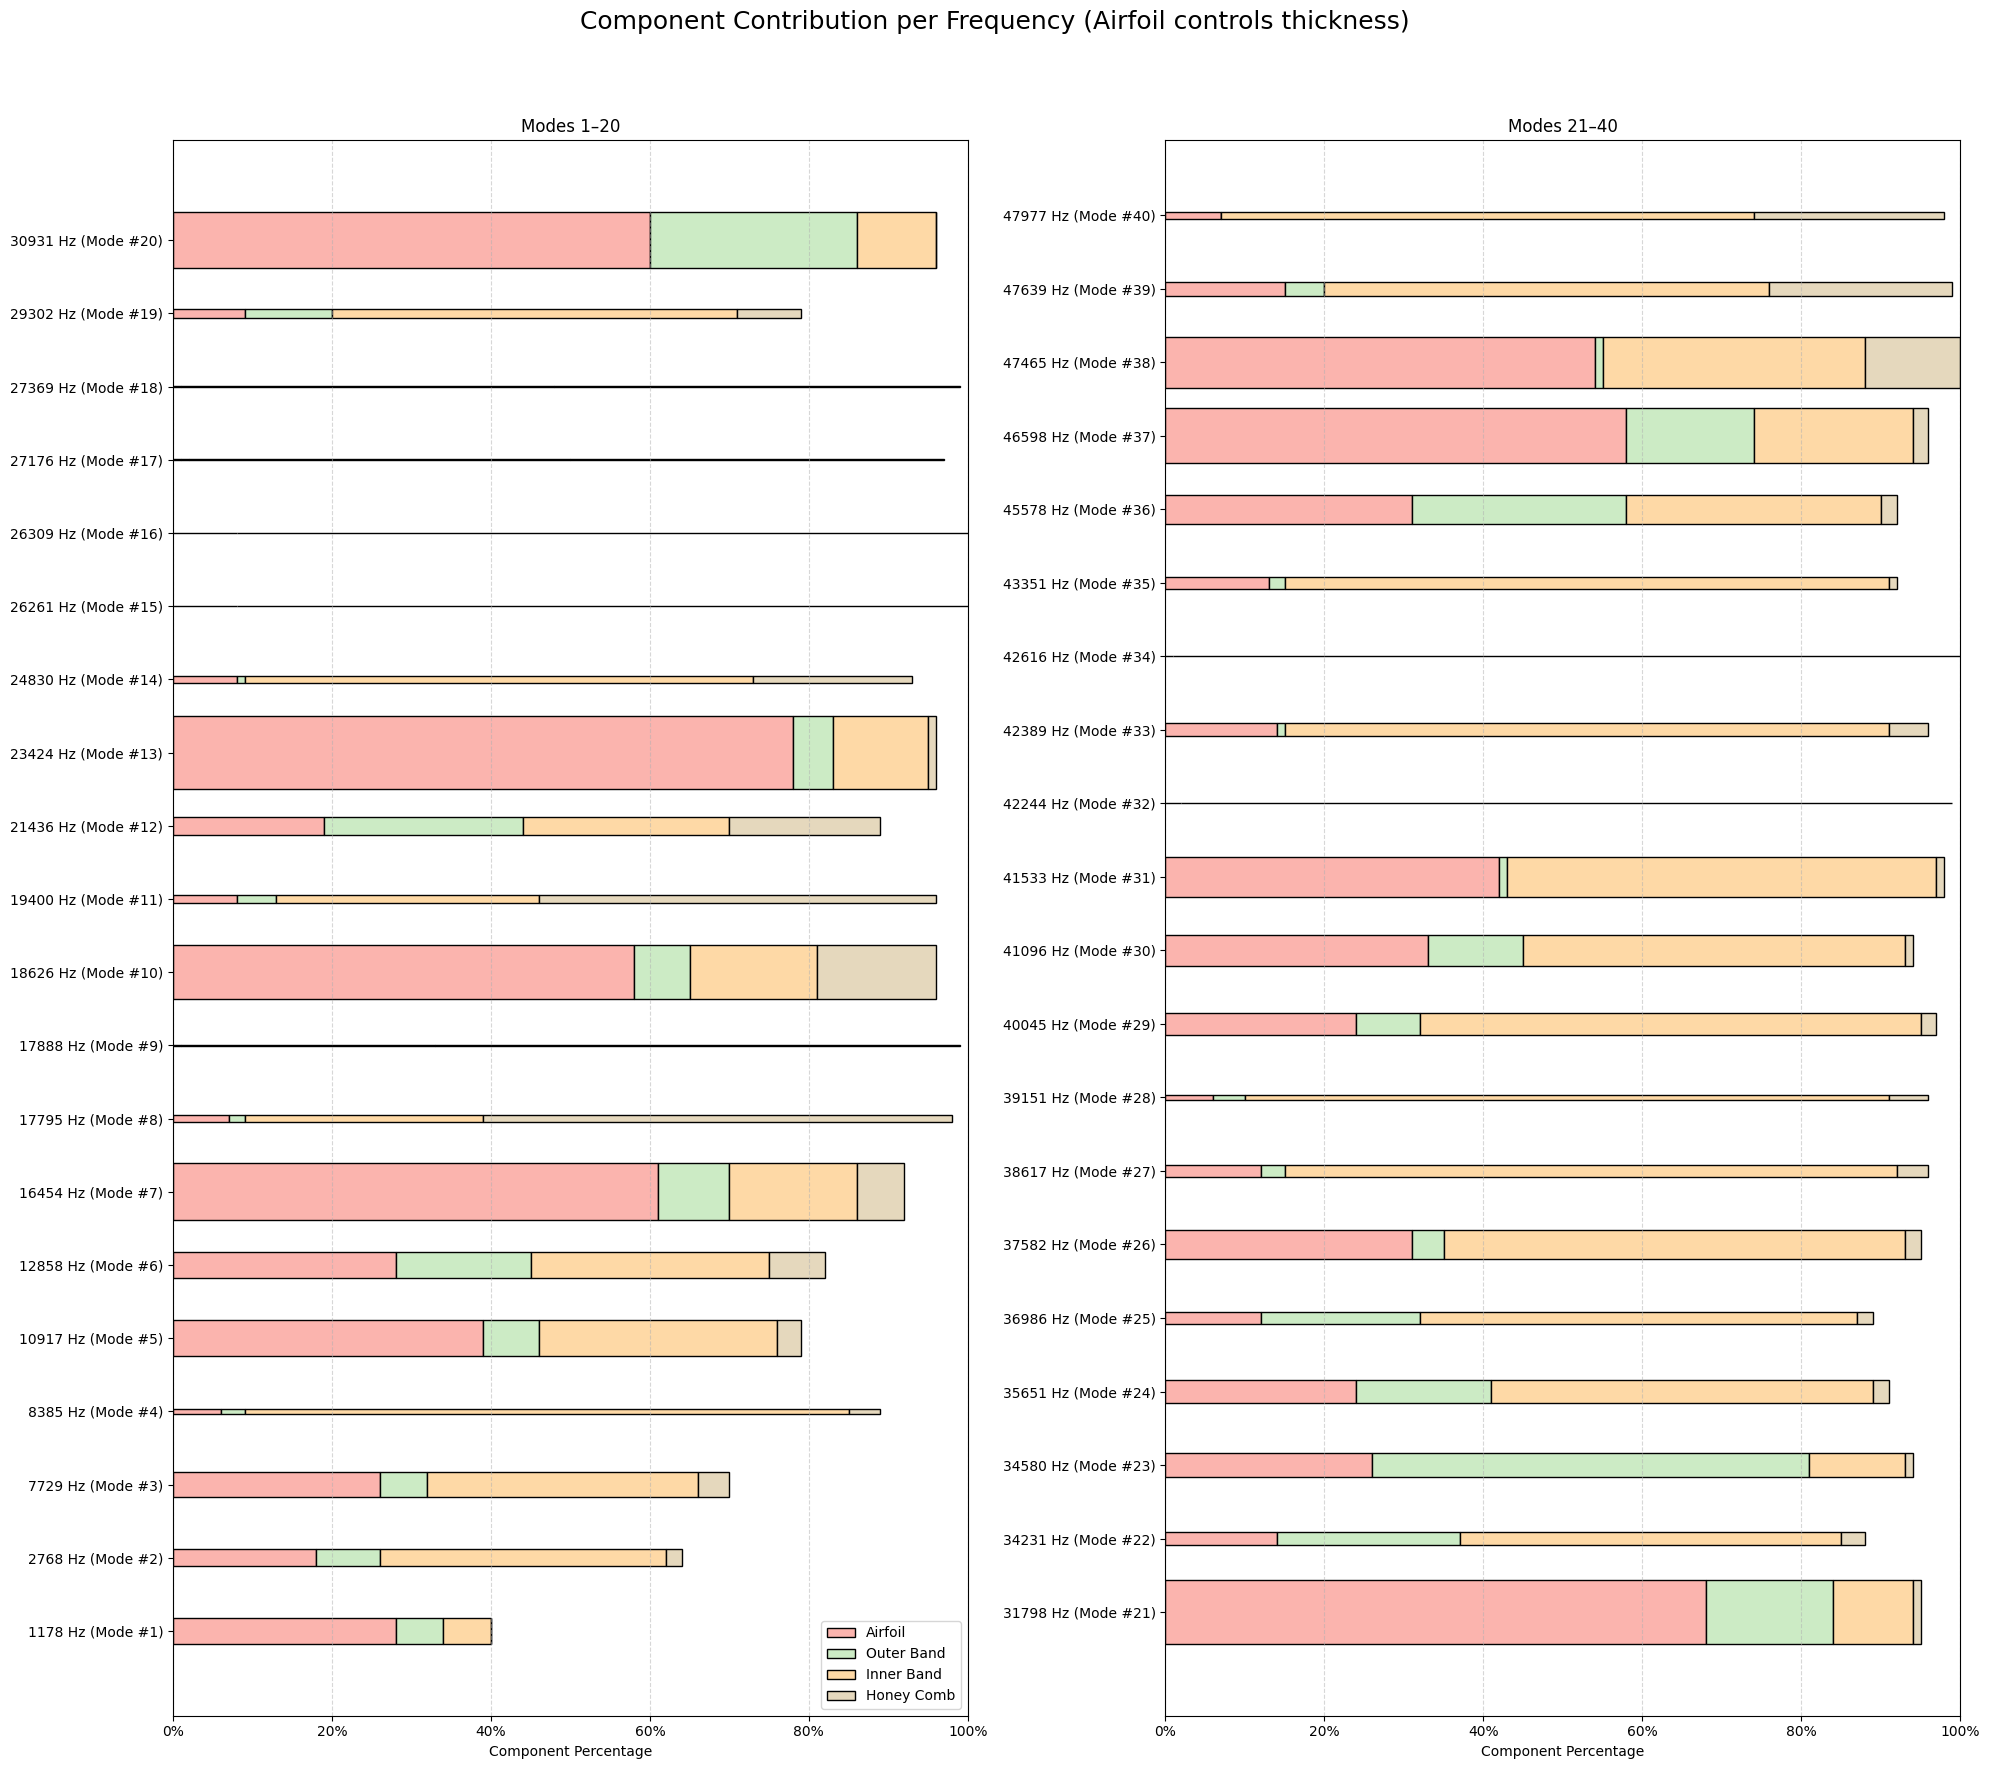

In [11]:


# Wczytanie danych
df_raw = pd.read_excel("reordered_processed_data_SED.xlsx", skiprows=1)
df_raw = df_raw.dropna(subset=["Freq [Hz]"])

component_df = pd.DataFrame()
component_df["Freq [Hz]"] = df_raw["Freq [Hz]"]

for comp in ["Airfoil", "Outer Band", "Inner Band", "Honey Comb"]:
    for i in range(1, 5):
        name_col = f"Comp {i}"
        value_col = f"Comp {i} [%]"
        mask = df_raw[name_col] == comp
        component_df.loc[mask, f"{comp} [%]"] = (
            df_raw.loc[mask, value_col]
            .astype(str)
            .str.replace('%', '', regex=False)
            .astype(float)
        )

# Przygotuj dane
data = []
for _, row in component_df.iterrows():
    data.append({
        "Freq": row["Freq [Hz]"],
        "Airfoil": row["Airfoil [%]"],
        "Outer Band": row["Outer Band [%]"],
        "Inner Band": row["Inner Band [%]"],
        "Honey Comb": row["Honey Comb [%]"]
    })

components = ["Airfoil", "Outer Band", "Inner Band", "Honey Comb"]
max_airfoil = max(row["Airfoil"] for row in data)

# 🎨 Pastelowe kolory
cmap = plt.colormaps.get_cmap('Pastel1')
colors = {comp: mcolors.to_hex(cmap(i / len(components))) for i, comp in enumerate(components)}

# 🔁 Dzielimy dane na dwie grupy po 20 modów
chunks = [data[:20], data[20:40]]

# 🔳 Rysowanie dwóch subplotów obok siebie
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 18), sharex=True)
axs = axs.flatten()

for idx, (ax, chunk) in enumerate(zip(axs, chunks)):
    for i, row in enumerate(chunk):
        height = row["Airfoil"] / max_airfoil
        y_pos = i
        base = 0

        for comp in components:
            width = row[comp]
            if pd.isna(width):
                continue
            ax.barh(
                y=y_pos,
                width=width,
                left=base,
                height=height,
                color=colors[comp],
                edgecolor='black'
            )
            base += width

    # 🏷️ Etykiety Y: Freq + Mode
    first_idx = df_raw.index[df_raw["Freq [Hz]"] == chunk[0]["Freq"]][0]
    ax.set_yticks(range(len(chunk)))
    ax.set_yticklabels([
        f"{int(row['Freq'])} Hz (Mode #{int(df_raw.loc[first_idx + i, 'Mode'])})"
        for i, row in enumerate(chunk)
    ])
    ax.set_title(f"Modes {first_idx + 1}–{first_idx + len(chunk)}")
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    ax.set_xlim(0, 1)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    ax.set_xlabel("Component Percentage")

# Legenda i tytuł ogólny
axs[0].legend(components, loc="lower right")
fig.suptitle("Component Contribution per Frequency (Airfoil controls thickness)", fontsize=18)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()